In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler
from torch.nn import CrossEntropyLoss


In [ ]:
# Load the dataset
csv_file_path = "/content/investigator_nacc63.csv"
df = pd.read_csv(csv_file_path)

<ipython-input-2-d9d4e9a60af2>:3: DtypeWarning: Columns (20,22,24,26,28,41,44,46,48,51,61,63,65,67,69,71,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,134,156,165,176,179,189,217,220,222,224,226,228,230,232,234,236,238,240,242,244,246,248,250,252,254,256,258,260,262,264,266,268,270,272,382,397,399,401,419,421,423,432,445,454,494,574,605,613,638,674,690,704,707,710,715,727,738,744,746,803,804,809,810,811,812,820,831,833,835,837,843,904,959,960,961,969,970,971,972,982,1004,1007,1010) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path)


#**Data Explorations**

In [ ]:
# Display the first few rows of the dataset
df.head()

,NACCID,NACCADC,PACKET,FORMVER,VISITMO,VISITDAY,VISITYR,NACCVNUM,NACCAVST,NACCNVST,...,NPATGAM1,NPATGAM2,NPATGAM3,NPATGAM4,NPATGAM5,NPATGFRN,NPATGFR1,NPATGFR2,NPATGFR3,NPATGFR4
0,NACC002909,186,I,3.0,12,28,2022,1,1,1,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
1,NACC004352,186,I,3.0,10,5,2021,1,1,1,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
2,NACC004687,186,I,3.0,11,14,2022,1,1,1,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
3,NACC008514,186,I,3.0,11,15,2022,1,1,1,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
4,NACC013667,186,I,3.0,3,29,2022,1,1,1,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4


In [ ]:
# Display basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183097 entries, 0 to 183096
Columns: 1024 entries, NACCID to NPATGFR4
dtypes: float64(133), int64(749), object(142)
memory usage: 1.4+ GB


In [ ]:
# Display summary statistics
df.describe()

,NACCADC,FORMVER,VISITMO,VISITDAY,VISITYR,NACCVNUM,NACCAVST,NACCNVST,NACCDAYS,NACCFDYS,...,NPATGAM1,NPATGAM2,NPATGAM3,NPATGAM4,NPATGAM5,NPATGFRN,NPATGFR1,NPATGFR2,NPATGFR3,NPATGFR4
count,183097.000000,183097.000000,183097.000000,183097.000000,183097.000000,183097.000000,183097.000000,183097.000000,183097.000000,183097.000000,...,183097.000000,183097.000000,183097.000000,183097.000000,183097.000000,183097.000000,183097.000000,183097.000000,183097.000000,183097.000000
mean,5045.374386,2.313191,6.364457,15.427145,2013.810385,3.762399,6.524798,5.693059,2369.898764,1174.117304,...,-3.940927,-3.939507,-3.941932,-3.940097,-3.940742,-3.924259,-3.980251,-3.979104,-3.979044,-3.980371
std,2963.788303,0.699132,3.394358,8.603537,4.992962,3.005342,4.086922,3.837000,1698.312003,1259.653794,...,0.629914,0.655855,0.628480,0.642091,0.634493,0.722048,0.358551,0.375612,0.378239,0.361455
min,186.000000,1.000000,1.000000,1.000000,2005.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000
25%,2289.000000,2.000000,3.000000,8.000000,2010.000000,1.000000,3.000000,3.000000,1058.000000,0.000000,...,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000
50%,5310.000000,2.000000,6.000000,15.000000,2014.000000,3.000000,6.000000,5.000000,2061.000000,777.000000,...,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000
75%,8361.000000,3.000000,9.000000,23.000000,2018.000000,5.000000,9.000000,8.000000,3626.000000,1823.000000,...,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000
max,9661.000000,3.200000,12.000000,31.000000,2023.000000,18.000000,18.000000,18.000000,6524.000000,6524.000000,...,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000


In [ ]:
# Sum of missing values for each column
missing_values = df.isnull().sum()
missing_values

,0
NACCID,0
NACCADC,0
PACKET,0
FORMVER,0
VISITMO,0
...,...
NPATGFRN,0
NPATGFR1,0
NPATGFR2,0
NPATGFR3,0


In [ ]:
# Total number of missing values
missing_values.nunique()

160

In [ ]:
df['NACCID'].value_counts()

,count
NACCID,
NACC870859,18
NACC270893,18
NACC642177,18
NACC285855,18
NACC147305,18
...,...
NACC140320,1
NACC276828,1
NACC282010,1


In [ ]:
#Unique number of subjects
df['NACCID'].nunique()

49412

In [ ]:
df['NACCID'].isnull().sum()

0

In [ ]:
df['NACCVNUM'].nunique()

18

In [ ]:
# Missing value in NACCVNUM column
df['NACCVNUM'].isnull().sum()

0

In [ ]:
# Assuming 'BIRTHYR' is the column you want to extract values from
birthyr_column = 'BIRTHYR'

In [ ]:
# Display the first 10 values of the 'BIRTHYR' column
first_10_values = df[birthyr_column].head(10)
print(f'First 10 values of {birthyr_column} column:\n{first_10_values}')

First 10 values of BIRTHYR column:
0    1952
1    1958
2    1945
3    1936
4    1945
5    1952
6    1947
7    1938
8    1952
9    1958
Name: BIRTHYR, dtype: int64


#**Data Preprocessing for LSTM Model**

In [ ]:
# Function for preprocessing
def preprocess_data(df):
    # Define the columns to keep
    feature_cols = ['SEX', 'BIRTHYR', 'NACCMMSE', 'CDRGLOB', 'NACCALZP', 'BOSTON', 'TRAILA', 'TRAILB',
                    'CSFTAU', 'TAUPETAD', 'AMYLCSF', 'AMYLPET', 'DIABET', 'AFIBRILL', 'HYPERT', 'HYPCHOL',
                    'VB12DEF', 'THYDIS', 'ANGIOPCI', 'NACCALZD', 'PENTAGON', 'BRNINJ', 'DEP', 'EPILEP',
                    'SCHIZOP', 'PTSDDX', 'OTHPSY', 'ALCDEM', 'IMPSUB', 'MEDS']

    # Create 'AGE' column, convert 'BIRTHYR' to 'AGE'
    current_year = pd.to_datetime('today').year
    df['AGE'] = current_year - df['BIRTHYR']
    df = df.drop(columns=['BIRTHYR'])  # Drop the 'BIRTHYR' column

    # Update feature_cols to reflect the new 'AGE' column
    feature_cols[feature_cols.index('BIRTHYR')] = 'AGE'

    # Identify and encode categorical columns (excluding 'NACCUDSD')
    object_columns = df.select_dtypes(include='object').columns
    for col in object_columns:
        if col != 'NACCUDSD':  # Exclude the target variable from label encoding
            df[col] = pd.factorize(df[col])[0]

    # Handle 'inf' and 'NaN' values in numerical columns
    numerical_columns = df[feature_cols].select_dtypes(include=['float64', 'int64']).columns
    df[numerical_columns] = df[numerical_columns].replace([np.inf, -np.inf], np.nan).fillna(0)

    # Normalize features: Apply MinMaxScaler only to numerical columns
    scaler = MinMaxScaler()
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

    # Mapping for the target variable (class labels)
    class_mapping = {1: 0, 2: 1, 3: 2, 4: 3}
    df['NACCUDSD'] = df['NACCUDSD'].map(class_mapping)

    # Define target features
    target = df['NACCUDSD']

    # Include 'NACCVNUM' for time step in the feature columns
    feature_cols.append('NACCVNUM')

    # Filter the dataframe to keep only selected feature columns, target column, NACCID and NACCVNUM
    df = df[feature_cols + ['NACCUDSD', 'NACCID']]

    return df, feature_cols, target


In [ ]:
# Perform preprocessing
df, feature_cols, target = preprocess_data(df)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183097 entries, 0 to 183096
Data columns (total 33 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   SEX       183097 non-null  float64
 1   AGE       183097 non-null  float64
 2   NACCMMSE  183097 non-null  float64
 3   CDRGLOB   183097 non-null  float64
 4   NACCALZP  183097 non-null  float64
 5   BOSTON    183097 non-null  float64
 6   TRAILA    183097 non-null  float64
 7   TRAILB    183097 non-null  float64
 8   CSFTAU    183097 non-null  float64
 9   TAUPETAD  183097 non-null  float64
 10  AMYLCSF   183097 non-null  float64
 11  AMYLPET   183097 non-null  float64
 12  DIABET    183097 non-null  float64
 13  AFIBRILL  183097 non-null  float64
 14  HYPERT    183097 non-null  float64
 15  HYPCHOL   183097 non-null  float64
 16  VB12DEF   183097 non-null  float64
 17  THYDIS    183097 non-null  float64
 18  ANGIOPCI  183097 non-null  float64
 19  NACCALZD  183097 non-null  float64
 20  PENT

In [ ]:
df.isnull().sum()

,0
SEX,0
AGE,0
NACCMMSE,0
CDRGLOB,0
NACCALZP,0
BOSTON,0
TRAILA,0
TRAILB,0
CSFTAU,0
TAUPETAD,0


In [ ]:
# Display the first few rows of the preprocessed dataset
df.head(10)

,SEX,AGE,NACCMMSE,CDRGLOB,NACCALZP,BOSTON,TRAILA,TRAILB,CSFTAU,TAUPETAD,...,EPILEP,SCHIZOP,PTSDDX,OTHPSY,ALCDEM,IMPSUB,MEDS,NACCVNUM,NACCUDSD,NACCID
0,0.0,0.476636,0.0,0.005051,0.000000,0.0,0.054890,0.090818,1.000000,1.0,...,0.8,0.8,0.8,0.0,0.0,0.8,0.0,1,2,0
1,1.0,0.420561,0.0,0.010101,0.000000,0.0,0.153693,0.998004,1.000000,1.0,...,0.8,0.8,0.8,0.0,0.0,0.8,0.0,1,3,1
2,0.0,0.542056,0.0,0.000000,1.000000,0.0,0.066866,0.111776,1.000000,1.0,...,0.8,0.8,0.8,0.0,0.0,0.8,0.0,1,0,2
3,0.0,0.626168,0.0,0.005051,0.142857,0.0,0.074850,0.303393,1.000000,1.0,...,0.8,0.8,0.8,0.0,0.0,0.8,0.0,1,3,3
4,0.0,0.542056,0.0,0.010101,0.000000,0.0,0.063872,0.303393,1.000000,1.0,...,0.8,0.8,0.8,0.0,0.0,0.8,0.0,1,3,4
5,1.0,0.476636,0.0,0.000000,1.000000,0.0,0.047904,0.089820,1.000000,1.0,...,0.8,0.8,0.8,0.0,0.0,0.8,0.0,1,0,5
6,0.0,0.523364,0.0,0.005051,0.857143,0.0,0.050898,0.271457,1.000000,1.0,...,0.8,0.8,0.8,0.0,0.0,0.8,0.0,1,3,6
7,0.0,0.607477,0.0,0.000000,1.000000,0.0,0.028942,0.067864,1.000000,1.0,...,0.8,0.8,0.8,0.0,0.0,0.8,0.0,1,0,7
8,1.0,0.476636,0.0,0.020202,0.000000,0.0,0.123752,0.998004,0.416667,1.0,...,0.8,0.8,0.8,0.0,0.0,0.8,0.0,1,3,8
9,1.0,0.420561,0.0,0.000000,1.000000,0.0,0.032934,0.071856,1.000000,1.0,...,0.8,0.8,0.8,0.0,0.0,0.8,0.0,1,0,9


# **VISIUALISATION FUNCTIONS SECTION BEGINS**

In [ ]:
# function for tree map plotting
import plotly.express as px

def generate_treemap(df, column, labels=None, value_range=None):
    # Filter the DataFrame based on the specified value range
    if value_range is not None:
        df = df[df[column].between(*value_range)]

    # Get unique categories/values from the specified column
    categories = df[column].unique()

    # Create a DataFrame for counting occurrences of each category
    count_df = pd.DataFrame(index=categories, columns=['Count'])

    # Fill the DataFrame with counts
    for category in categories:
        count_df.loc[category, 'Count'] = (df[column] == category).sum()

    # Reset the index for plotting
    count_df = count_df.reset_index()

    # Rename columns for better plot labels
    count_df.columns = ['Category', 'Count']

    # Create a treemap using plotly
    title = f'Distribution of {column} Categories'
    if value_range is not None:
        title += f' (Values between {value_range[0]} and {value_range[1]})'

    fig = px.treemap(count_df, path=['Category'], values='Count', title=title)

    # Show the interactive treemap
    fig.show()

In [ ]:
# function for scatter and 2D density plot
import matplotlib.pyplot as plt
import seaborn as sns

def plot_column_vs_column(df, x_column, y_column, plot_type='scatter', values_range=None, **kwargs):
    """
    Plot a column against another column and display correlation value.

    Parameters:
    - df: DataFrame
    - x_column: str, column name for the x-axis
    - y_column: str, column name for the y-axis
    - plot_type: str, 'scatter' or 'density', default is 'scatter'
    - values_range: tuple or list, range of values to include in the plot (optional)
    - **kwargs: additional keyword arguments for customization

    Returns:
    - None
    """
    plt.figure(figsize=(12, 6))

    if values_range:
        df_filtered = df[df[x_column].isin(values_range)]
    else:
        df_filtered = df

    if plot_type == 'scatter':
        sns.scatterplot(x=df_filtered[x_column], y=df_filtered[y_column], **kwargs)
        plt.title(f'Scatter Plot of {x_column} vs {y_column}')
    elif plot_type == 'density':
        sns.kdeplot(x=df_filtered[x_column], y=df_filtered[y_column], fill=True, cmap='viridis', levels=20, **kwargs)
        plt.title(f'2D Density Plot of {x_column} vs {y_column}')

    plt.xlabel(x_column)
    plt.ylabel(y_column)

    # Calculate and display correlation value
    correlation_coefficient = df_filtered[x_column].corr(df_filtered[y_column])
    plt.text(0.5, 0.95, f'Correlation: {correlation_coefficient:.2f}', horizontalalignment='center',
             verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)

    plt.show()

In [ ]:
# Function for bar cahrt
import seaborn as sns
import matplotlib.pyplot as plt

def plot_bar_chart(df, column, title=None, xlabel=None, ylabel=None, hue=None, palette=None, custom_labels=None, show_legend=True):
    """
    Plot a bar chart for a specified column in the DataFrame.

    Parameters:
    - df: DataFrame
    - column: str, column name for the bar chart
    - title: str, title of the plot (optional)
    - xlabel: str, label for the x-axis (optional)
    - ylabel: str, label for the y-axis (optional)
    - hue: str, column name for grouping (optional)
    - palette: list, custom color palette for bars (optional)
    - custom_labels: dict, custom labels for specific values in the column (optional)
    - show_legend: bool, whether to show the legend (default is True)

    Returns:
    - None
    """
    plt.figure(figsize=(10, 6))

    if palette is None:
        palette = 'Set2'  # Default seaborn color palette

    sns.countplot(x=column, data=df, hue=hue, palette=palette)

    plt.title(title if title else f'Bar Chart for {column}')
    plt.xlabel(xlabel if xlabel else column)
    plt.ylabel(ylabel if ylabel else 'Count')

    if custom_labels:
        # Explicitly set the x-axis ticks at the center of each bar
        unique_values = df[column].unique()
        x_ticks_positions = range(len(unique_values))
        plt.xticks(x_ticks_positions, labels=[custom_labels.get(value, value) for value in unique_values])

    if show_legend and hue:
        # Modify legend labels to show both original values and custom labels
        legend_labels = [f"{value} ({custom_labels.get(value, value)})" for value in df[hue].unique()]
        plt.legend(title=hue, labels=legend_labels)

    plt.show()

In [ ]:
# Histogram plot function
import seaborn as sns
import matplotlib.pyplot as plt

def plot_histogram(df, column, title=None, xlabel=None, ylabel=None, color='blue', value_range=None, bins=20):
    """
    Plot a histogram for a specified column in a DataFrame.

    Parameters:
    - df: DataFrame
    - column: str, column name
    - title: str, plot title (optional)
    - xlabel: str, x-axis label (optional)
    - ylabel: str, y-axis label (optional)
    - color: str, color of the histogram bars (default is 'blue')
    - bins: int or sequence, number of bins or bin edges (default is 20)

    Returns:
    - None
    """
    plt.figure(figsize=(10, 6))

    # Plot histogram using Seaborn
    sns.histplot(df[column], color=color, bins=bins)

    # Set plot title and labels
    plt.title(title if title else f'Histogram of {column}')
    plt.xlabel(xlabel if xlabel else column)
    plt.ylabel(ylabel if ylabel else 'Frequency')

    # Show the plot
    plt.show()

In [ ]:
# two column barchart comparison

import seaborn as sns
import matplotlib.pyplot as plt

def plot_count_distribution(df, column1, column2, value_range=None, palette='Set2', legend_labels=None):
    """
    Plot the count distribution of two columns in the DataFrame.

    Parameters:
    - df: DataFrame
    - column1: str, column name for the x-axis
    - column2: str, column name for the hue (grouping)
    - value_range: tuple or list, range of values to include in the plot (optional)
    - palette: str or list, color palette for the plot (optional)
    - legend_labels: dict, custom labels for the legend (optional)

    Returns:
    - None
    """
    # Filter the DataFrame based on the specified value range
    if value_range is not None:
        df_filtered = df[df[column1].between(*value_range)]
    else:
        df_filtered = df

    # Map numerical values to labels
    df_filtered[column2] = df_filtered[column2].map(legend_labels)

    # Count the occurrences of each combination of column1 and column2
    count_df = df_filtered.groupby([column2, column1]).size().reset_index(name='Count')

    # Create a bar plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x=column1, y='Count', hue=column2, data=count_df, palette=palette)

    # Set plot title and labels
    plt.title(f'Number of {column2}s Across {column1} Scores')
    plt.xlabel(column1)
    plt.ylabel('Count')

    # Customize legend labels
    if legend_labels:
        plt.legend(title=column2, labels=legend_labels)

    # Show the plot
    plt.show()

# **Class balancing of target variables**

In [ ]:
# Print class distribution
print("Class distribution:")
print(df['NACCUDSD'].value_counts())

Class distribution:
NACCUDSD
0    87792
3    55306
2    31914
1     8085
Name: count, dtype: int64


<ipython-input-22-0213af92607c>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=df, hue=hue, palette=palette)


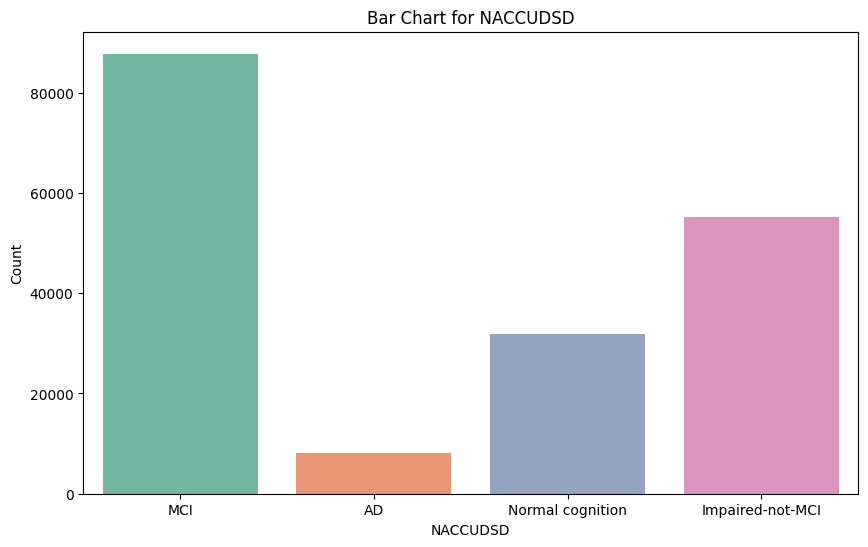

In [ ]:
# visaulising target variable before class balancing
desired_column = 'NACCUDSD'
custom_labels = {0: 'Normal cognition', 1: 'Impaired-not-MCI', 2: 'MCI', 3: 'AD'}  # Labels
plot_bar_chart(df, desired_column, custom_labels=custom_labels, show_legend=True)

In [ ]:
# Class balancing
# Separate the majority and minority classes
majority_class = df[df['NACCUDSD'] == 0]
minority_class_2 = df[df['NACCUDSD'] == 3]
minority_class_1 = df[df['NACCUDSD'] == 2]
minority_class_0 = df[df['NACCUDSD'] == 1]
# Oversample the minority classes to match the size of the majority class
minority_oversampled_2 = minority_class_2.sample(len(majority_class), replace=True, random_state=42)
minority_oversampled_1 = minority_class_1.sample(len(majority_class), replace=True, random_state=42)
minority_oversampled_0 = minority_class_0.sample(len(majority_class), replace=True, random_state=42)

# Concatenate the majority class with the oversampled minority classes
balanced_df = pd.concat([majority_class, minority_oversampled_2, minority_oversampled_1, minority_oversampled_0])

# Shuffle the DataFrame to ensure randomness
balanced_df = balanced_df.sample(frac=1, random_state=42)

# Update the target column name if needed
df = balanced_df

In [ ]:
# Print class distribution
print("Class distribution:")
print(df['NACCUDSD'].value_counts())

Class distribution:
NACCUDSD
2    87792
0    87792
3    87792
1    87792
Name: count, dtype: int64


<ipython-input-22-0213af92607c>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=df, hue=hue, palette=palette)


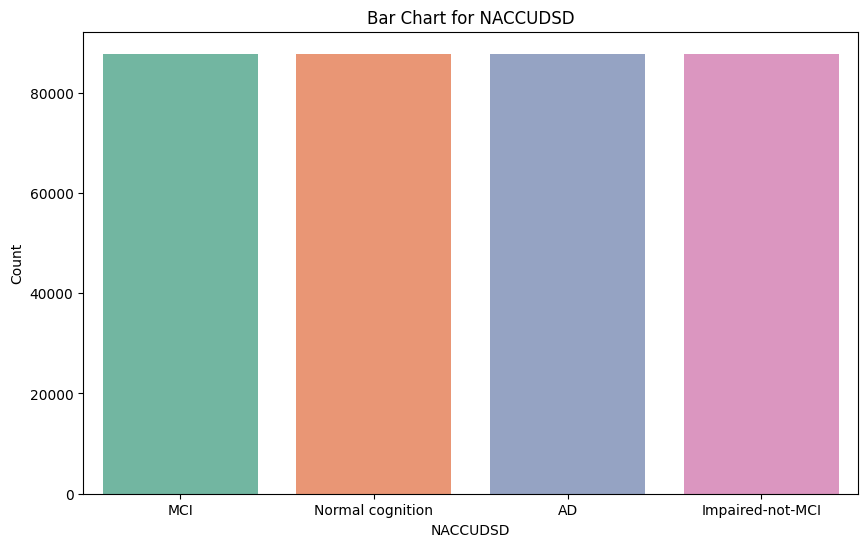

In [ ]:
# Viualising target variable after class balancing
desired_column = 'NACCUDSD'
custom_labels = {0: 'Normal cognition', 1: 'Impaired-not-MCI', 2: 'MCI', 3: 'AD'}  # Labels
plot_bar_chart(df, desired_column, custom_labels=custom_labels, show_legend=True)

# **VISUALISATION CALLS**

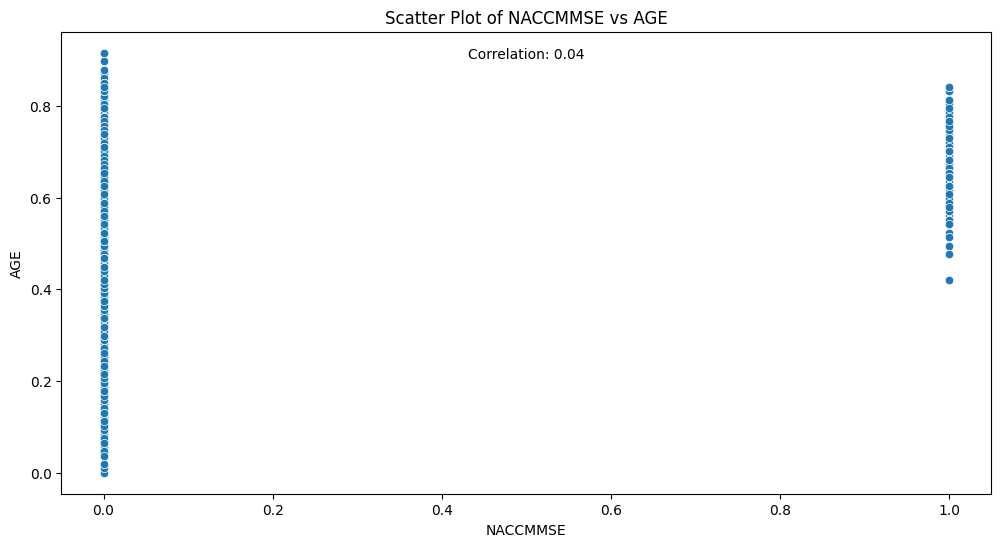

In [ ]:
# scatter plot for Age against MMSE score
plot_column_vs_column(df, 'NACCMMSE', 'AGE', plot_type='scatter', values_range=(range(31)))

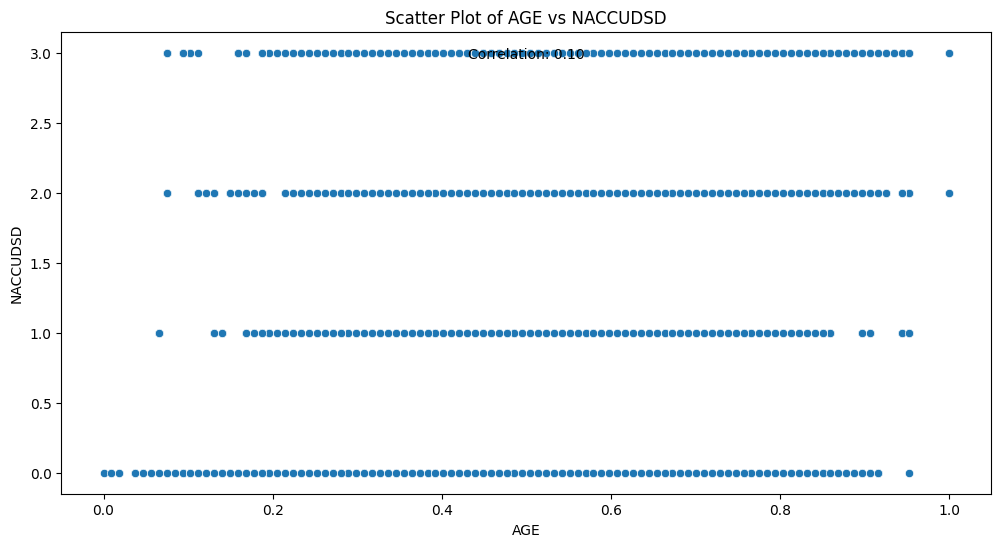

In [ ]:
# correlation scatter plot for AGE against target variable NACCUDSD
plot_column_vs_column(df, 'AGE', 'NACCUDSD', plot_type='scatter')

In [ ]:
# Treemap plot for Age distribution
generate_treemap(df, 'AGE')

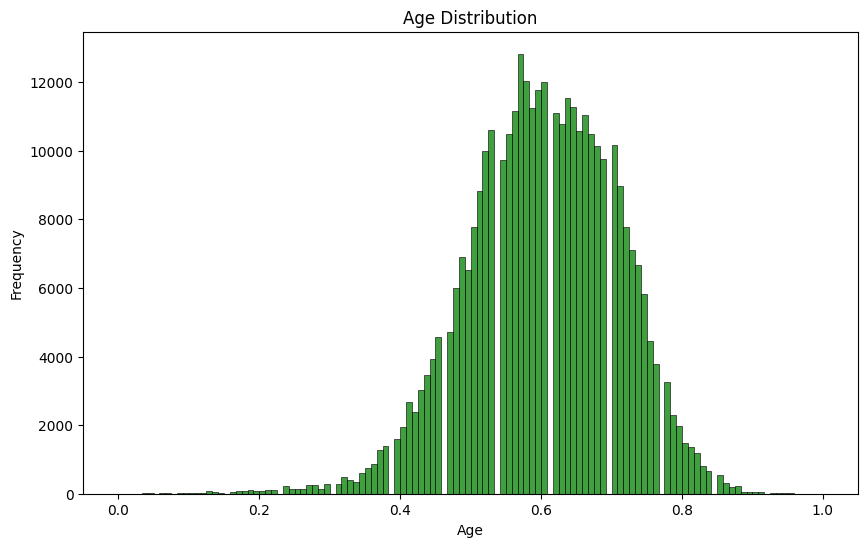

In [ ]:
# Histogram Plot for Age distribution
plot_histogram(df, 'AGE', title='Age Distribution', xlabel='Age', ylabel='Frequency', color='green', bins=120)

In [ ]:
# Distribution of all value in Total MMSE score 'NACCMMSE' column
generate_treemap(df, 'NACCMMSE')

In [ ]:
# Distribution of total MMSE score 'NACCMMSE' value 0 to 30 only
generate_treemap(df, 'NACCMMSE', value_range = (0,30))

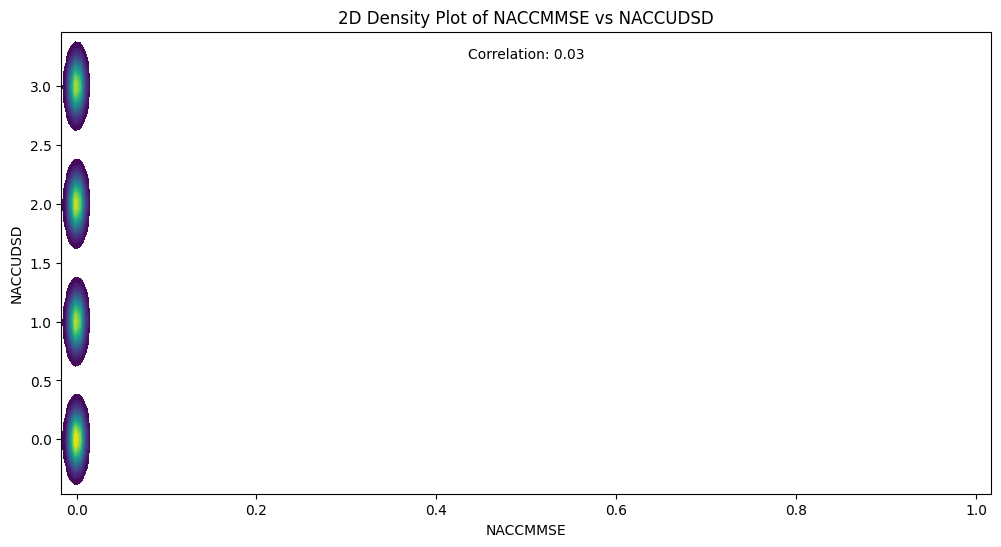

In [ ]:
# 2D density correlation plot for Total MMSE score against target ‘NACCUDSD’
plot_column_vs_column(df, 'NACCMMSE', 'NACCUDSD', plot_type='density', values_range=(range(31)))

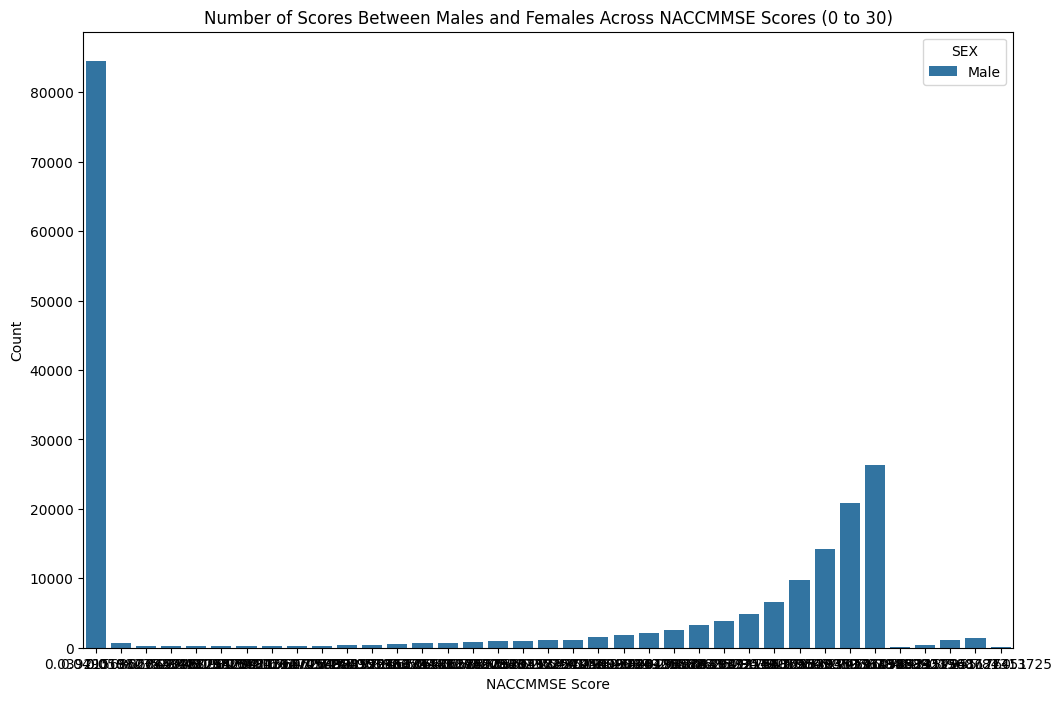

In [ ]:
# Histogram of the Total MMSE score 0 to 30 across gender
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the dataframe for scores between 0 and 30
df_filtered = df[(df['NACCMMSE'] >= 0) & (df['NACCMMSE'] <= 30)]

# Map the numerical values in 'SEX' to labels
df_filtered['SEX'] = df_filtered['SEX'].map({1: 'Male', 2: 'Female'})

# Count the occurrences of each combination of 'SEX' and 'NACCMMSE'
score_counts = df_filtered.groupby(['SEX', 'NACCMMSE']).size().reset_index(name='Count')

# Create a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x='NACCMMSE', y='Count', hue='SEX', data=score_counts)
plt.title('Number of Scores Between Males and Females Across NACCMMSE Scores (0 to 30)')
plt.xlabel('NACCMMSE Score')
plt.ylabel('Count')
plt.show()

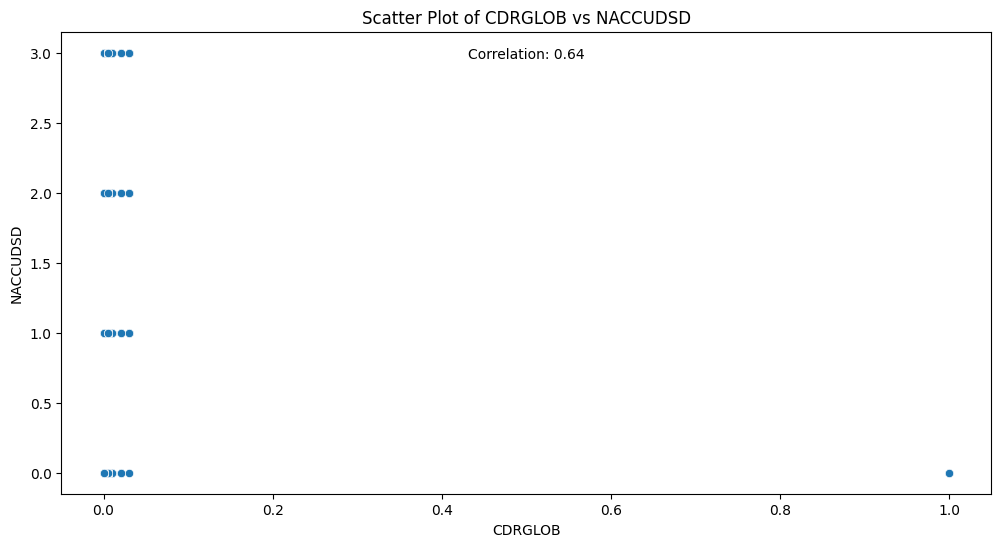

In [ ]:
# correlation scatter plot for CDRGLOB against target variable NACCUDSD
plot_column_vs_column(df, 'CDRGLOB', 'NACCUDSD', plot_type='scatter')

In [ ]:
# #2D density plot for Global CDR 'CDRGLOB' score against target column 'NACCUDSD'
# plot_column_vs_column(df, 'CDRGLOB', 'NACCUDSD', plot_type='density', values_range=(range(31)))

In [ ]:
# Check the distribution of the target variable
print("Class distribution:\n", df['NACCUDSD'].value_counts())

Class distribution:
 NACCUDSD
2    87792
0    87792
3    87792
1    87792
Name: count, dtype: int64


# **Defining train and evaluate LSTM Model**

---





In [ ]:

# Define the LSTM model with Dropout
class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.3):
        super(MyLSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout_rate if num_layers > 1 else 0,  # Dropout applies only if num_layers > 1
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x, lengths):
        # Pack padded sequences
        packed_inputs = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_out, _ = self.lstm(packed_inputs)
        lstm_out, _ = pad_packed_sequence(packed_out, batch_first=True)

        # Extract the output of the last valid time step for each sequence
        last_outputs = lstm_out[torch.arange(lstm_out.size(0)), lengths - 1]

        # Pass through the fully connected layer
        out = self.fc(last_outputs)
        return out

In [ ]:
# Define Dynamic Collate Function
from torch.nn.utils.rnn import pad_sequence

def dynamic_collate_fn(batch):
    """
    Custom collate function to dynamically pad sequences and prepare batch tensors.
    Args:
        batch: List of (sequence, length, label) tuples from the dataset.
    Returns:
        padded_sequences: Tensor of padded sequences.
        lengths: Tensor of original sequence lengths.
        labels: Tensor of labels.
    """
    # Unpack the batch
    sequences, lengths, labels = zip(*batch)

    # Pad sequences dynamically
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)

    # Convert lengths and labels to tensors
    lengths = torch.tensor(lengths, dtype=torch.long)
    labels = torch.tensor(labels, dtype=torch.long)

    return padded_sequences, lengths, labels

In [ ]:
grouped = df.groupby('NACCID')

In [ ]:
# Prepare sequences
sequences = []
labels = []
sequence_lengths = []  # Store the lengths of the sequences

for _, group in grouped:
    features = group.drop(columns=['NACCUDSD', 'NACCVNUM']).values  # All columns except target and time step
    sequence = torch.tensor(features, dtype=torch.float32)
    label = group['NACCUDSD'].iloc[-1]  # Use the last diagnosis as the label for the sequence
    sequences.append(sequence)
    labels.append(label)

# Now split the data

# Train-test split (using padded sequences and their corresponding lengths)
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [ ]:
# Create datasets
train_dataset = list(zip(X_train, [len(seq) for seq in X_train], y_train))
val_dataset = list(zip(X_val, [len(seq) for seq in X_val], y_val))
test_dataset = list(zip(X_test, [len(seq) for seq in X_test], y_test))

# Create DataLoader with dynamic collate function
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=dynamic_collate_fn, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=dynamic_collate_fn, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=dynamic_collate_fn, shuffle=False)

In [ ]:
# Set hyperparameters
# Get the input size from the first sequence in the training data
input_size = X_train[0].shape[1]  # Number of features per timestep, assuming all sequences have the same shape
hidden_size = 300  # increased from 256
num_layers = 6  # Increased from 4
num_classes = len(torch.unique(torch.tensor(y_train)))  # Number of unique target classes # Convert y_train to a tensor
dropout_rate = 0.3
learning_rate = 0.0005
num_epochs = 50

In [ ]:
# Instantiate the model, loss function, and optimizer
model = MyLSTM(input_size, hidden_size, num_layers, num_classes, dropout_rate)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, threshold=1e-3)

In [ ]:
# Move model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MyLSTM(
  (lstm): LSTM(31, 300, num_layers=6, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=300, out_features=4, bias=True)
)

In [ ]:
# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, delta=0, verbose=False):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [ ]:
# Training loop with gradient clipping, scheduler, and early stopping
early_stopping = EarlyStopping(patience=5)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for features, lengths, labels in train_loader:
        # Move features and labels to the device, but keep lengths on the CPU
        features, labels = features.to(device), labels.to(device)

        # Ensure lengths is on the CPU and of type int64
        lengths = lengths.cpu().to(torch.int64)

        optimizer.zero_grad()
        outputs = model(features, lengths)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        total_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0  # Initialize val_loss before accumulating it

    with torch.no_grad():
        for features, lengths, labels in val_loader:
            # Move features and labels to the device
            features, labels = features.to(device), labels.to(device)

            # Ensure lengths is on CPU and converted to int64
            lengths = lengths.cpu().to(torch.int64)

            # Forward pass
            val_outputs = model(features, lengths)

            # Accumulate validation loss
            val_loss += criterion(val_outputs, labels).item()

    # Average validation loss over all batches
    val_loss /= len(val_loader)

    # Adjust learning rate based on validation loss
    scheduler.step(val_loss)

    # Print the current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch + 1}: Learning Rate: {current_lr:.6f}")

    # Check for early stopping
    if early_stopping(val_loss):
        print(f"Early stopping triggered at epoch {epoch + 1}")
        break

    # Print epoch results
    print(f"Epoch {epoch + 1}, Train Loss: {total_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}")


Epoch 1: Learning Rate: 0.000500
Epoch 1, Train Loss: 1.1386, Val Loss: 1.1209
Epoch 2: Learning Rate: 0.000500
Epoch 2, Train Loss: 1.1120, Val Loss: 1.1279
Epoch 3: Learning Rate: 0.000500
Epoch 3, Train Loss: 1.1123, Val Loss: 1.1179
Epoch 4: Learning Rate: 0.000500
Epoch 4, Train Loss: 1.1114, Val Loss: 1.1169
Epoch 5: Learning Rate: 0.000500
Epoch 5, Train Loss: 1.1104, Val Loss: 1.1197
Epoch 6: Learning Rate: 0.000500
Epoch 6, Train Loss: 1.1098, Val Loss: 1.1180
Epoch 7: Learning Rate: 0.000500
Epoch 7, Train Loss: 1.1094, Val Loss: 1.1201
Epoch 8: Learning Rate: 0.000500
Epoch 8, Train Loss: 1.1096, Val Loss: 1.1199
Epoch 9: Learning Rate: 0.000500
Epoch 9, Train Loss: 1.1092, Val Loss: 1.1158
Epoch 10: Learning Rate: 0.000500
Epoch 10, Train Loss: 1.1085, Val Loss: 1.1183
Epoch 11: Learning Rate: 0.000500
Epoch 11, Train Loss: 1.1081, Val Loss: 1.1170
Epoch 12: Learning Rate: 0.000500
Epoch 12, Train Loss: 1.1081, Val Loss: 1.1203
Epoch 13: Learning Rate: 0.000500
Epoch 13, Tr

In [ ]:
# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for features, lengths, labels in test_loader:
        # Move features and labels to the correct device
        features, labels = features.to(device), labels.to(device)

        # Ensure lengths is on the CPU and of type int64
        lengths = lengths.cpu().to(torch.int64)

        # Forward pass through the model
        outputs = model(features, lengths)

        # Get predictions by selecting the class with the maximum score
        _, preds = torch.max(outputs, 1)

        # Collect all predictions and labels for evaluation
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays for further evaluation
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

# Print the metrics
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")


Accuracy: 0.4329, Precision: 0.4277, Recall: 0.4329, F1 Score: 0.4013


In [ ]:
y_train_tensor = torch.tensor(y_train)
print(f"Unique classes in y_train: {torch.unique(y_train_tensor)}")
print(f"Number of unique classes: {len(torch.unique(y_train_tensor))}")


Unique classes in y_train: tensor([0, 1, 2, 3])
Number of unique classes: 4
